In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
from scipy.stats import beta
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts

In [2]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)
    
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')
beta_peak_indir = os.path.join(consts['official_indir'], 'Beta Peak Decomposition')

In [3]:
clinical = {}

clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv'), index_col=0)
clinical['Ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['Ringner']['spf'] = clinical['Ringner']['spfPercent'] / 100
clinical['Ringner']['log_spf'] = np.log(clinical['Ringner']['spf'])

In [4]:
for dataset in clinical:
    print(dataset)
    modes = pd.read_csv(os.path.join(beta_peak_indir, dataset, 'readable_tables','modes.txt'), sep=' ')
    
    if dataset == 'TCGA':
        modes = modes.rename(index=epi_util.sampleToPatientID)
    
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_middle'] = modes.apply(lambda x: np.sort(x)[1], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    clinical[dataset]['avg_n_flips_estA'] = -np.log(1 - 2 * clinical[dataset]['beta_A']) / 2
    clinical[dataset]['avg_n_flips_estB'] = -np.log(2 * clinical[dataset]['beta_B'] - 1) / 2
    clinical[dataset]['avg_n_flips'] = (clinical[dataset]['avg_n_flips_estA'] + clinical[dataset]['avg_n_flips_estB'])
    
    clinical[dataset] = clinical[dataset].loc[(clinical[dataset]['beta_middle'] >= 0.4) & (clinical[dataset]['beta_middle'] <= 0.6)]
    
clinical['TCGA'] = clinical['TCGA'].loc[clinical['TCGA']['subtype.pam50'] != 'Normal']
clinical['Ringner'] = clinical['Ringner'].loc[clinical['Ringner']['genefu.pam50.subtype'] != 'Normal']

TCGA
Ringner


In [5]:
# scale factor
sf = 0.4

figsize = np.array([7, 6])
labelfontsize = 25
ticksfontsize = 18
signif_fontsize = 14
opacity = 0.8
linewidth = 1
fliersize = 1

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [6]:
phi = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'phi.txt'), sep=' ').rename(index=lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))


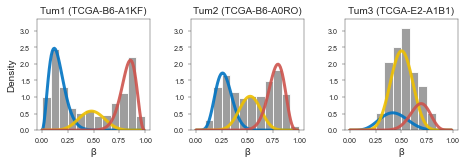

In [7]:
patient_list = {'Tum1':'TCGA-B6-A1KF',
               'Tum2':'TCGA-B6-A0RO',
               'Tum3':'TCGA-E2-A1B1'}

fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

beta_values_balancedSites_TCGA = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.methyl.balancedSites.tsv'),
                      index_col=0).rename(columns=epi_util.sampleToPatientID)
alpha = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'alpha.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
delta = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'delta.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
phi = pd.read_table(os.path.join(beta_peak_indir, 'TCGA', 'readable_tables', 'phi.txt'), sep=' ').rename(index=lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))

chosen_tumor_colors = [consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    ax = axes[i]
    
    samp = patient_list[patient]
    cur_color = chosen_tumor_colors[i]
    
    sns.histplot(ax=ax, x=beta_values_balancedSites_TCGA[samp], stat='density',
#                 color=cur_color,
                 color=consts['palette_jco'][2],
                 bins=12, alpha=opacity,
                binrange=(0, 1))
    
    ax.set_title(f'{patient} ({samp})', fontsize=labelfontsize * sf)
    ax.set_xlabel('β', fontsize=labelfontsize * sf)
    if i == 0:
        ax.set_ylabel('Density', fontsize=labelfontsize * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

    frac_list = phi.loc[samp]
    
    y_max = float('-Inf')
    
    for j, model in enumerate(alpha.columns):
        
        a = alpha.loc[samp, model]
        d = delta.loc[samp, model]

        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * frac_list[j]
        ax.plot(x, y, lw=3, alpha=0.9,
                color=chosen_tumor_colors[j]
               )
        
        y_max = max(y_max, ax.get_ylim()[1])

for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.03)

fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

In [8]:
predictors = [
    'Stroma', 'Lipid', 'IR', 'Mitotic Checkpoint', 'Mitotic Progression', 'Basal', 'Early Response', 'SR',
    'FGA', 'LUMP'
]

response = 'log_spf'

train_data = clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], predictors + [response]].dropna()
train_X = train_data[predictors]
train_y = train_data[response]

TCGA_X = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], predictors].dropna()

In [9]:
eNetCV = ElasticNetCV(alphas=np.linspace(0.01, 0.99, 20), l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
eNetCV.fit(train_X, train_y)

print(f'alpha = {eNetCV.alpha_}')
print(f'l1 ratio = {eNetCV.l1_ratio_}')

y_pred = eNetCV.predict(train_X)
r2 = r2_score(train_y, y_pred)
print(f'R^2 = {r2:.2f}')

alpha = 0.01
l1 ratio = 0.1
R^2 = 0.71


In [10]:
clinical['TCGA'].loc[TCGA_X.index, response] = eNetCV.predict(TCGA_X)
clinical['TCGA']['spf'] = np.exp(clinical['TCGA']['log_spf'])

s_phase_duration_hrs = np.mean([12.40, 11.70, 13.60, 12.95, 12.66])
s_phase_duration = s_phase_duration_hrs / 24

# Growth rate with 1 day as time unit
for dataset in clinical:
    clinical[dataset]['growth_rate'] = clinical[dataset]['spf'] / s_phase_duration
    clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['avg_n_flips'] / clinical[dataset]['growth_rate']

In [11]:
## Mean S-phase durations

print(np.mean(1 / clinical['TCGA']['growth_rate']))
print(np.mean(1 / clinical['Ringner']['growth_rate']))

10.369010978589543
9.218451378295832


In [12]:
## Mean growth rates

print(np.mean(clinical['TCGA']['growth_rate']))
print(np.mean(clinical['Ringner']['growth_rate']))

0.1642052837603301
0.1995496504832257


In [13]:
## Flip rate

flip_rate_TCGA = clinical['TCGA']['calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_Ringner = clinical['Ringner']['calendar_age_prod_flip_rate'].median() / (3 * 365)

print(f'TCGA-predicted flip rate: {flip_rate_TCGA:.4f}')
print(f'Lund-predicted flip rate: {flip_rate_Ringner:.4f}')

TCGA-predicted flip rate: 0.0043
Lund-predicted flip rate: 0.0039


In [14]:
# combined

combined_intermed_df = pd.concat([clinical['TCGA'][['in_analysis_dataset', 'calendar_age_prod_flip_rate']],
clinical['Ringner'][['in_analysis_dataset', 'calendar_age_prod_flip_rate']]],
          axis=0)
flip_rate_est = combined_intermed_df.loc[combined_intermed_df['in_analysis_dataset'],
                                         'calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_est

0.004353325968286623

In [15]:
for dataset in clinical:
    clinical[dataset]['mitotic_age'] = clinical[dataset]['avg_n_flips'] / flip_rate_est
    clinical[dataset]['calendar_age_years'] = clinical[dataset]['calendar_age_prod_flip_rate'] / flip_rate_est / 365

<Axes: title={'center': 'TCGA'}, ylabel='Proliferation rate'>

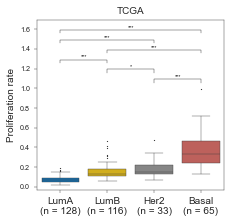

In [16]:
clinical['TCGA'].name = 'TCGA'
epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='growth_rate', ylabel='Proliferation rate',
                   outdir='figures', title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.15, signif_bar_heights=0.1,
                   figsize=figsize * [1.2, 1.3], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'Lund'}, ylabel='Proliferation rate'>

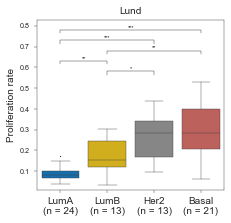

In [20]:
clinical['Ringner'].name = 'Lund'
epi_util.saveBoxPlotNew(clinical['Ringner'], 'genefu.pam50.subtype', restrict=True,
                   var_y='growth_rate', ylabel='Proliferation rate',
                   outdir='figures', title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.15, signif_bar_heights=0.05,
                   figsize=figsize * [1.2, 1.3], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

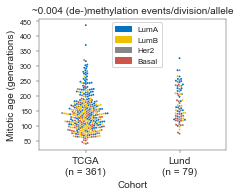

In [25]:
fig, ax = plt.subplots(figsize=figsize * [1.2, 1] * sf)

df_ch1 = pd.DataFrame({'mitotic_age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'mitotic_age':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'mitotic_age'],
                       'Subtype':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

color_list = consts['palette_jco'][:4]
color_dict = dict(zip(['LumA', 'LumB', 'Her2', 'Basal'], color_list))

sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='mitotic_age',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)

ax.set_title(f'~{flip_rate_est:.3f} (de-)methylation events/division/allele', fontsize=labelfontsize * sf)
ax.set_xlabel('Cohort', fontsize=labelfontsize * sf)
ax.set_ylabel('Mitotic age (generations)', fontsize=labelfontsize * sf)

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=labelfontsize * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*labelfontsize * sf
          )

fig.savefig(os.path.join(figure_outdir, 'mitotic_age.pdf'), format='pdf', pad_inches=0.1)

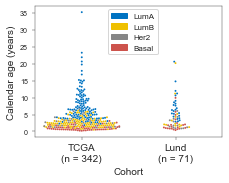

In [24]:
fig, ax = plt.subplots(figsize=figsize * [1.2, 1] * sf)

df_ch1 = pd.DataFrame({'calendar_age_years':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'subtype.pam50'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'calendar_age_years':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'calendar_age_years'],
                       'Subtype':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'genefu.pam50.subtype'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

color_list = consts['palette_jco'][:4]
color_dict = dict(zip(['LumA', 'LumB', 'Her2', 'Basal'], color_list))

sns.swarmplot(ax=ax, data=df_combined, x='cohort',
              y='calendar_age_years',
              hue='Subtype',
              palette=color_dict,
              legend=False,
             s=12 * sf**2)
ax.set_xlabel('Cohort', fontsize=labelfontsize * sf)
ax.set_ylabel('Calendar age (years)', fontsize=labelfontsize * sf)

ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=labelfontsize * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

patches = [mpatches.Patch(color=color_dict[group], label=group) for group in color_dict.keys()]
plots_x, plots_y = ax.get_position().get_points()[1]
fig.legend(handles=patches,
           loc='upper right',
           bbox_to_anchor=(0.65, plots_y + .005),
           fontsize=0.8*labelfontsize * sf
          )

fig.savefig(os.path.join(figure_outdir, 'calendar_age.pdf'), format='pdf', pad_inches=0.1)